In [2]:
import numpy as np
import scipy as sp
from scipy import integrate
from math import pi, tanh
from cmath import sqrt
from scipy.linalg import block_diag
import sys
from os import path
import matplotlib.pyplot as plt
from ipywidgets import interact

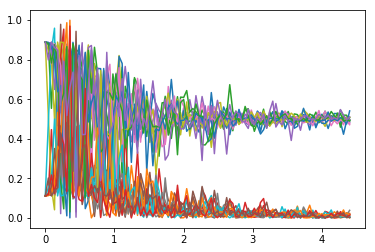

Average is computed over 13 reps.


In [13]:

avg_dir='Dis1d_avg_files/'
out_dir='Dis1d_data_files/'

nu=1
if nu==1:
    D1=0.2 #0.4
    D2=.0 # 0.
    k0=1.2
    L=40/D1

else:
    D1=0.1
    D1t=0.
    D2=0.2
    k0u=2.2
    k0d=1.
    L=40/D2

Nrep=100
Nimp=40
Uimp=1.
Zsw=[1.0]

def wf_avg(Uimp,Z):
    N_avg=0
    plt.figure()
    f1='nu%d_delta_D12_%.2f_%.2f_Z_%.2f_Ni_%d_L_%d' % (nu,D1,D2,Z,Nimp,int(L*D1))


    for i_r in range(Nrep):
        fname=out_dir+f1+'_%d.npz' % (i_r)

#         fname=out_dir+'nu1_D2_%.2f_Z_%.2f_Ni_%d_U_%.2f_L_%d_%d.npz' % (D2,Z,Nimp,Uimp,int(L*D1),i_r)

        if path.exists(fname):
            N_avg += 1
            npzfile = np.load(fname)
            if N_avg==1:
                E_list=npzfile['E_list']
                Ree=npzfile['Ree']
                Reh=npzfile['Reh']
                plt.plot(E_list,npzfile['Ree'])
                plt.plot(E_list,npzfile['Reh'])
            else:
                plt.plot(E_list,npzfile['Ree'])
                plt.plot(E_list,npzfile['Reh'])
                Ree += npzfile['Ree']
                Reh += npzfile['Reh']
    plt.show()
    if N_avg>0:
        Reh= Reh/N_avg
        Ree= Ree/N_avg
#         fname=avg_dir+'avg_nu1_D2_%.2f_Z_%.2f_Ni_%d_U_%.2f_L_%d.npz' % (D2,Z,Nimp,Uimp,int(L*D1))
#         fname=avg_dir+'avg_nu%d_delta_D12_%.2f_%.2f_Z_%.2f_Ni_%d_L_%d.npz' % (nu,D1,D2,Z,Nimp,int(L*D1))
        fname= avg_dir+ 'avg_' + f1 + '.npz'
        np.savez(fname, E_list=E_list, Ree=Ree, Reh=Reh, N_avg = N_avg)
        
    return N_avg

for Z in Zsw:
    N_avg= wf_avg(Uimp=Uimp,Z=Z)
    print("Average is computed over %d reps." % (N_avg) )

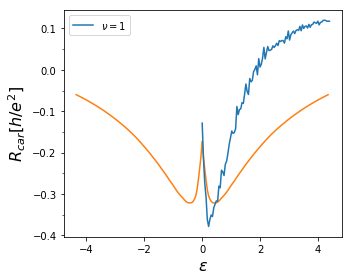

In [21]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

k0=1.2
k0u=2.2
k0d=1.

def clean_limit(nu,Z,Esw):
    # T matrix with Z

    Ree=np.zeros(len(Esw))
    Reh=np.zeros(len(Esw))

    
    s0=np.array([[1,0],[0,1]])
    sx=np.array([[0,1],[1,0]])
    sy=np.array([[0,-1j],[1j,0]])
    sz=np.array([[1,0],[0,-1]])
    s_up=(sz+s0)/2
    s_dn=(s0-sz)/2


    if nu==1:
        Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy) 
        vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
        Hd= np.linalg.inv(vk)

        for i_E in range(len(Esw)):
            E=Esw[i_E]
            Ht= np.dot(Hd,E*np.eye(4)-  Ham)
            evs, evecs = np.linalg.eig(Ht)

            i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
            ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
            ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

            i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
            evecs_inv=np.linalg.inv(evecs)
            Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[4,])
            ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
            ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

            i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
            i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

            evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
            Tevecs = evecs[:,i_T]    
            Revecs = evecs[:,i_R]    
            evecs_0= np.concatenate((Tevecs,Revecs),axis=1)

            Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
            Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
            evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

            Tmat=sp.linalg.solve(evecs_0,evecs_l)
            Tz=[[1-1j*Z,0,-1j*Z,0],\
                [0,1+1j*Z,0,-1j*Z],\
                [1j*Z,0,1+1j*Z,0],\
                [0,1j*Z,0,1-1j*Z]]
            Tt=np.dot(Tmat,Tz)
            TLL=Tt[np.ix_([2,3],[2,3])]
            TLR=Tt[np.ix_([2,3],[0,1])]
            x= -sp.linalg.solve(TLL,TLR)
            Ree[i_E] = np.abs(x[0,0])**2
            Reh[i_E] = np.abs(x[1,0])**2
    elif nu==2:
        Ham=  - k0u* np.kron(sz,np.kron(s0,s_up))\
            - k0d* np.kron(sz,np.kron(s0,s_dn))\
            + D1*np.kron(sy,np.kron(sx,sy))\
            + D1t*np.kron(sy,np.kron(s0,sy))\
            + D2*np.kron(sy,np.kron(sy,s0))

        vk= np.kron(s0,np.kron(sz,s0))
        Hd= np.linalg.inv(vk)


        for i_E in range(len(Esw)):
            E=Esw[i_E]
            Ht= np.dot(Hd,E*np.eye(8)-  Ham)
            evs, evecs = np.linalg.eig(Ht)

            i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
            ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
            ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

            i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
            evecs_inv=np.linalg.inv(evecs)
        #     evecs_inv=np.transpose(evecs)
            Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[8,])
            ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
            ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

            i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
            i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

            evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
            Tevecs = evecs[:,i_T]    
            Revecs = evecs[:,i_R]    
            evecs_0= np.concatenate((Tevecs,Revecs),axis=1)


            Revecs_l= np.kron(np.array([[0,1,0,0],[0,0,0,1]]).T,s0)
            Tevecs_l= np.kron(np.array([[1,0,0,0],[0,0,1,0]]).T,s0)
            evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

            Tmat=sp.linalg.solve(evecs_0,evecs_l)
            Tz=[[1-1j*Z,0,-1j*Z,0],\
                [0,1+1j*Z,0,-1j*Z],\
                [1j*Z,0,1+1j*Z,0],\
                [0,1j*Z,0,1-1j*Z]]
            Tt=np.dot(Tmat,np.kron(Tz,s0))
            TLL=Tt[np.ix_([4,5,6,7],[4,5,6,7])]
            TLR=Tt[np.ix_([4,5,6,7],[0,1,2,3])]
            x= -sp.linalg.solve(TLL,TLR)
        #     x= -np.dot(np.linalg.inv(TLL),TLR)
            Ree[i_E] = np.sum(np.abs(x[0,0:2])**2+np.abs(x[1,0:2])**2)
            Reh[i_E] = np.sum(np.abs(x[2,0:2])**2+np.abs(x[3,0:2])**2)

    return Ree, Reh

def wf_plot(nu,Nimp,Z):
    if nu==1:
        D1=0.2 #0.4
        D2=0. #0.
        L=40/D1

    else:
        D1=0.1
        D1t=0.
        D2=0.2
        L=40/D2

#     fname=avg_dir+'avg_nu1_D2_%.2f_Z_%.2f_Ni_%d_U_%.2f_L_%d.npz' % (D2,Z,Nimp,Uimp,int(L*D1))
    fname=avg_dir+'avg_nu%d_delta_D12_%.2f_%.2f_Z_%.2f_Ni_%d_L_%d.npz' % (nu,D1,D2,Z,Nimp,int(L*D1))

    npzfile = np.load(fname)
    Esw=npzfile['E_list']
    Ree=npzfile['Ree']
    Reh=npzfile['Reh']

    Esw0=np.linspace(0,4.4,1000)
    Ree0,Reh0= clean_limit(nu,Z=Z,Esw=Esw0)
    y0=nu-Ree0+Reh0 
    I0=integrate.cumtrapz(y0,Esw0)
    xplot=Esw0[0:len(Esw0)-1]
    yplot=nu*((Esw0[1:len(Esw0)]-Esw0[0])/I0[0:len(Esw0)-1])-1
#     yplot=I0[0:len(Esw0)-1]/(Esw0[1:len(Esw0)]-Esw0[0])
#     plt.plot(xplot,yplot,'-', c='C0')
#     plt.plot(-xplot,yplot,'-', c='C0')


    y=nu-Ree+Reh 
    I=integrate.cumtrapz(y,Esw)
    xplot=Esw[0:len(Esw)-1]
    yplot=nu*((Esw[1:len(Esw)]-Esw[0])/I[0:len(Esw)-1])-1
#     yplot=I[0:len(Esw)-1]/(Esw[1:len(Esw)]-Esw[0])
#     plt.plot(Esw,Ree-Reh,'.-', c='C2')
    plt.plot(xplot,yplot,'-', c='C1')
    plt.plot(-xplot,yplot,'-', c='C1')

#     plt.figure()
# #     plt.plot(Esw,Reh-Ree)
# #     plt.plot(Esw,Reh0-Ree0)
# #     plt.plot(Esw,Ree)
#     x0 = Ree0-Reh0
#     plt.plot(Esw,x0/(nu-x0))
# #     plt.plot(Esw,x0)
    x = Ree-Reh
# #     plt.plot(Esw,Ree-Reh)
    l= r'$\nu=%d$' % (nu)
# #     if Z>0.3:
# #         x[19:21]= 1.02*x[18]
#     if nu==1:
    plt.plot(Esw,x/(nu-x), label=l)
#     elif nu==2:
#         plt.plot(Esw,x/(nu-x), label=l)

#     plt.plot(Esw,x)

        
#     plt.plot(Esw,Ree0-Reh0)
    if Z==0:
        plt.grid()
#     plt.ylim(-.51,0.38)

    plt.xlabel(r'$r_{eh}$')
    plt.xlabel(r'$E$')
#     print(Esw[0],nu-y[0])
#     plt.show()

Z=.4
fig, ax = plt.subplots(figsize=(5,4))
wf_plot(nu=1,Nimp=40,Z=Z)
# wf_plot(nu=2,Nimp=40,Z=Z)

ax.legend()
fsize=16
plt.ylabel(r"$R_{car} [h/e^2]$",fontsize = fsize)
plt.xlabel(r"$\varepsilon$",fontsize = fsize)
# plt.xticks(np.arange(-0.08,0.081,0.04))
# plt.ylim(-0.3,0.3)
# plt.yticks(np.arange(-0.6,0.21,0.2))
# plt.legend(loc='upper right')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.tight_layout()
# plt.savefig('figs/CAR_dis_vs_E.pdf')
plt.show()

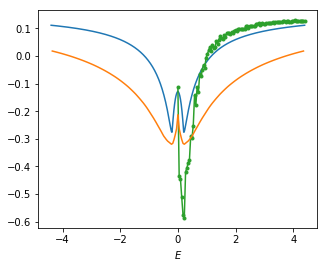

In [10]:
Nimp_sw=[40]
Zsw=[0.4]
# Zsw=np.arange(0,0.7,0.2)
fig, ax = plt.subplots(figsize=(5,4))
for Ni in Nimp_sw:
    for Z in Zsw:
        wf_plot(nu=1,Nimp=Ni,Z=Z)
#         wf_plot(nu=2,Nimp=Ni,Z=Z)

